# Dogs

The first submetric takes into account the one of the biggest threats posed to rats: predators. We used data for Allegheny County Dog Licenses collected from the Western Pennsylvania Regional DataCenter to determine the best City of Pittsburgh neighborhood to live in as a rat according to our metrics.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from fpsnippets import zip_to_neighborhoods, ZIPS, NEIGHBORHOODS
from tqdm import tqdm
from collections import Counter

First, let's go through the data and configure it for our needs. This data contains dogs from the entirety of Allegheny county, so we'll mask all entries that are not in the City of Pittsburgh. Additionally, the dogs' locations are organized with zip codes. Since we are looking for the best neighborhood, we'll also use helper functions to convert the zip codes into the neighborhood(s) they correspond with. 

In [2]:
tqdm.pandas(desc="Mapping ZIPs to neighborhoods")
dogs = pd.read_csv("Dogs.csv")

dogs['OwnerZip'] = dogs['OwnerZip'].astype(str)
ZIPS = ZIPS[ZIPS.geometry.intersects(NEIGHBORHOODS.union_all())]
pgh_zips = set(ZIPS["ZIP"].astype(str))

dogs = dogs[dogs['OwnerZip'].isin(pgh_zips)].copy()
dogs['neighborhoods'] = dogs['OwnerZip'].progress_apply(zip_to_neighborhoods)

all_neighborhoods = [n for sublist in dogs['neighborhoods'].dropna() for n in sublist]
neighborhood_counts = Counter(all_neighborhoods)
counts_df = pd.DataFrame(neighborhood_counts.items(), columns=['Neighborhood', 'DogCount'])
counts_df = counts_df.sort_values(by='DogCount', ascending=False)

print(counts_df)

Mapping ZIPs to neighborhoods: 100%|██████████| 22596/22596 [02:08<00:00, 176.05it/s]

                Neighborhood  DogCount
0                       Hays      6334
1   Lincoln-Lemington-Belmar      5234
4             Homewood North      3300
5                 East Hills      3282
10                 Overbrook      2783
..                       ...       ...
88     Central Lawrenceville        10
87           Central Oakland         9
83          Crawford-Roberts         8
79               Middle Hill         8
89       Upper Lawrenceville         6

[90 rows x 2 columns]


Now that we have a list of the number of dogs per neighborhood in the City of Pittsburgh, let's organize this data into a visual representation!

Here we have two graph representing the same data set. Since the first graph is so overcrowded as to be unreadable, we'll cut off the data set to the top twenty entries.

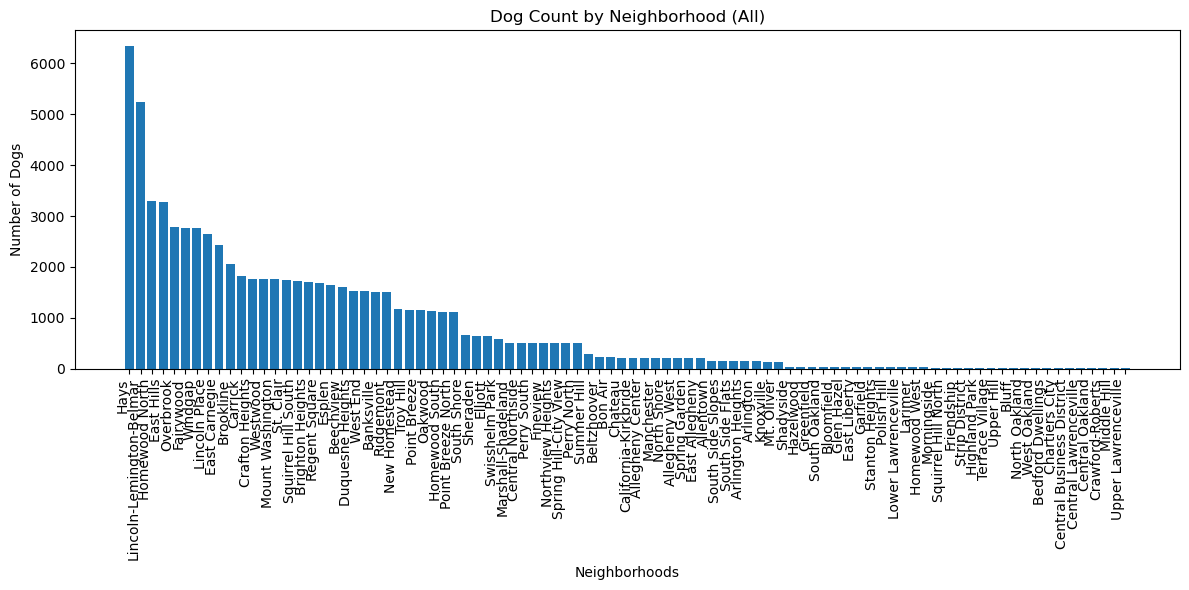

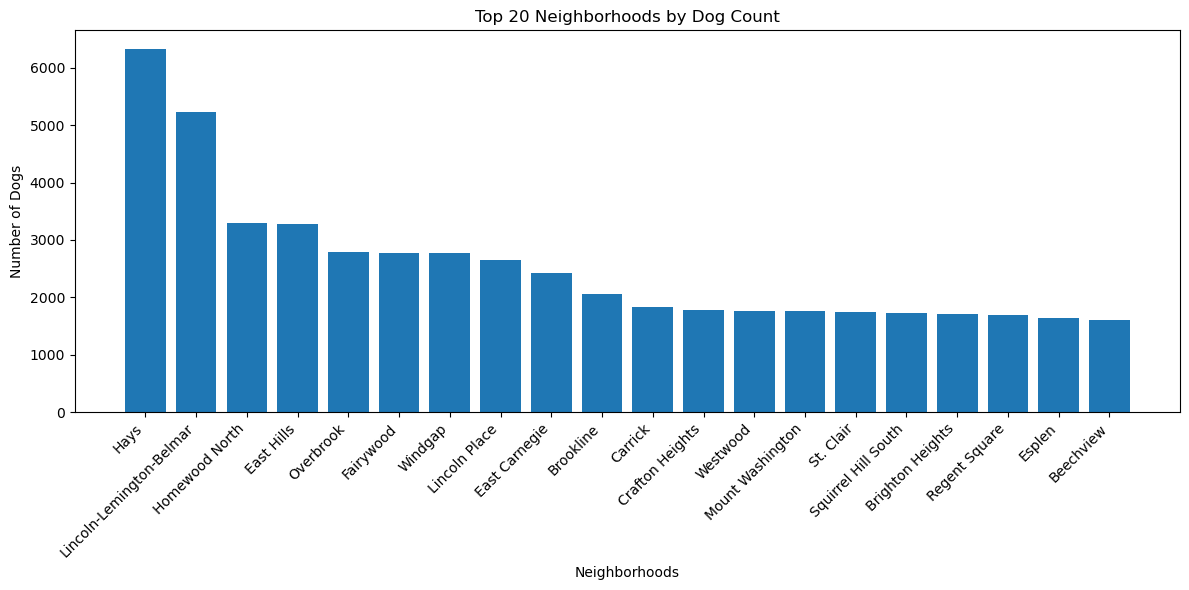

In [10]:
all_neiborhoods = [neiborhood for sublist in dogs['neighborhoods'].dropna() for neiborhood in sublist]
total_counts = Counter(all_neiborhoods)
total_df = pd.DataFrame(total_counts.items(), columns=['Neighborhood', 'DogCount']).sort_values(by='DogCount', ascending=False)

def plot_bar(df, xcol, ycol, title, xlabel='Neighborhoods', ylabel='Number of Dogs', top_n=None, rotation=45):
    plt.figure(figsize=(12, 6))
    plot_df = df if top_n is None else df.head(top_n)
    plt.bar(plot_df[xcol], plot_df[ycol])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    plt.show()

plot_bar(total_df, 'Neighborhood', 'DogCount', 'Dog Count by Neighborhood (All)',rotation=90)
plot_bar(total_df, 'Neighborhood', 'DogCount', 'Top 20 Neighborhoods by Dog Count', rotation=45, top_n=20)

Great! It looks like Hays is the neighborhood with the highest count of dogs. 

Let's dive further! While all dogs are a threat to rats, certain dog breeds pose significantly more of a danger than others since hunting instincts and avilities vary between breeds. Here, we'll organize the dog data between two categories: hunting and tracking dogs, and non hunting and tracking dogs. Now let's plot this information!

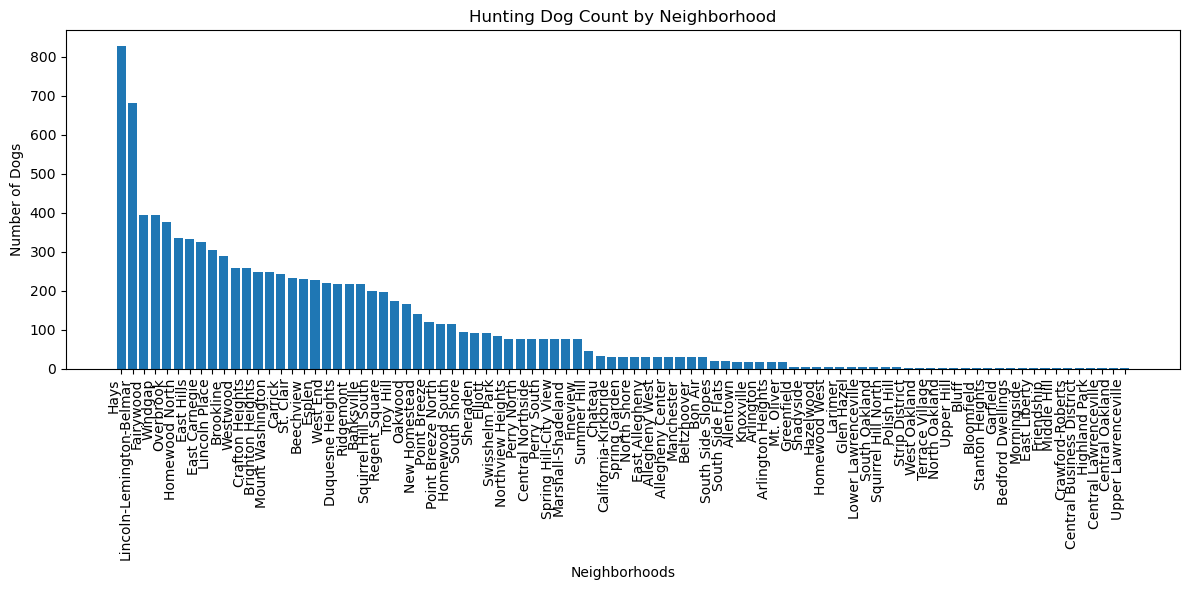

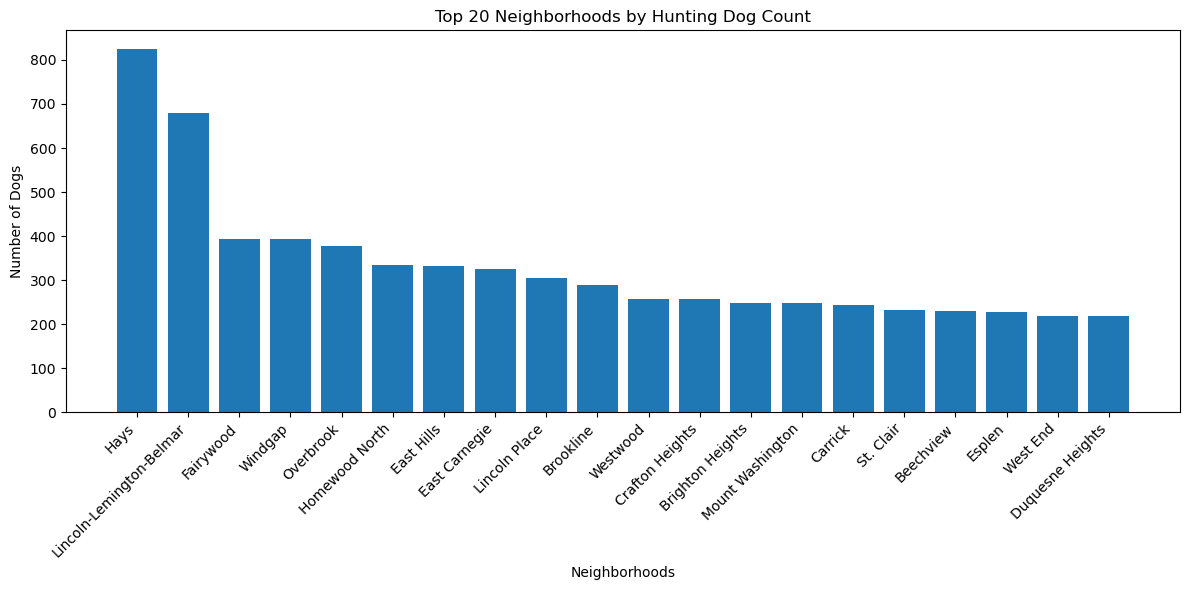

In [11]:
hunting_breeds = {
    'Beagle', 'Bloodhound', 'Coonhound', 'Pointer', 'Foxhound',
    'Weimaraner', 'Vizsla', 'Labrador Retriever', 'Golden Retriever',
    'German Shorthaired Pointer', 'Irish Setter', 'Bluetick Coonhound',
    'American Foxhound', 'Plott Hound', 'Treeing Walker Coonhound'
}

def assign_breed_weight(breed):
    if pd.isna(breed):
        return 1.0
    for hunter in hunting_breeds:
        if hunter.lower() in breed.lower():
            return 1.5  # Best hunters
    return 0.5  # Not hunting breeds

dogs['BreedWeight'] = dogs['Breed'].apply(assign_breed_weight)

hunting_counts = Counter()
for _, row in dogs.iterrows():
    if row['BreedWeight'] == 1.5 and isinstance(row['neighborhoods'], list):
        for neiborhood in row['neighborhoods']:
            hunting_counts[neiborhood] += 1

hunting_df = pd.DataFrame(hunting_counts.items(), columns=['Neighborhood', 'HuntingDogCount']).sort_values(by='HuntingDogCount', ascending=False)
plot_bar(hunting_df, 'Neighborhood', 'HuntingDogCount', 'Hunting Dog Count by Neighborhood', rotation=90)
plot_bar(hunting_df, 'Neighborhood', 'HuntingDogCount', 'Top 20 Neighborhoods by Hunting Dog Count', top_n=20)


Wow! While some of the neighborhoods certainly shifted, Hays is still in the lead! 

This data is great, but has an issue. In this list, a neighood with a singular Beagle is considered more dangerous than a neighborhood with fifty Chihuahuas. We want an even comparison that takes into account both the number of dogs and the breeds of the dogs. Let's create a weight system for our data. Here, hunting and tracking dogs will be multiplied for a wight of 1.5 while non hunting or tracking dogs will be weighed with a weight of 0.5. This will give us a data set that takes into account both the number of dogs and the breed of dogs in each neighborhood.

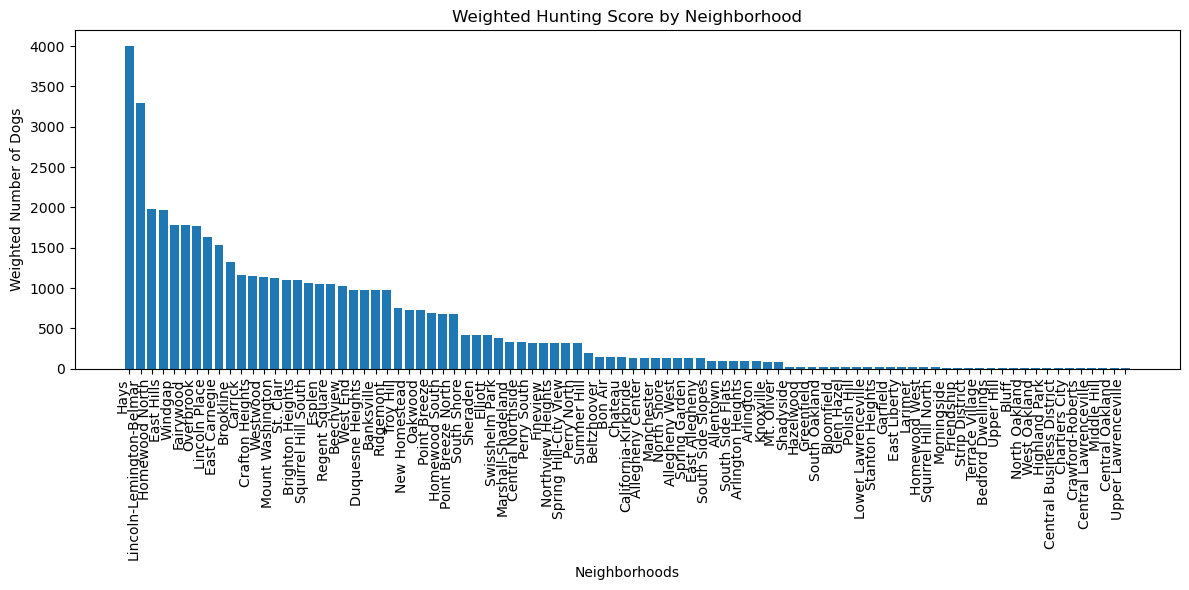

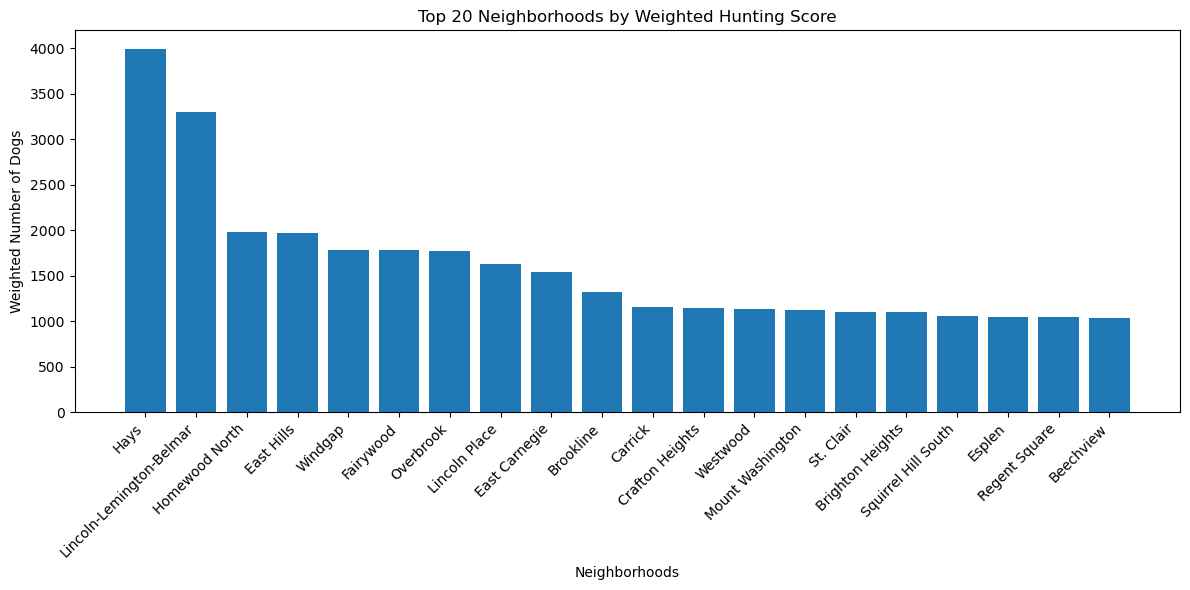

In [15]:
weighted_scores = Counter()
for _, row in dogs.iterrows():
    if isinstance(row['neighborhoods'], list):
        for neiborhood in row['neighborhoods']:
            weighted_scores[neiborhood] += row['BreedWeight']

weighted_df = pd.DataFrame(weighted_scores.items(), columns=['Neighborhood', 'WeightedScore']).sort_values(by='WeightedScore', ascending=False)

def plot_bar(df, xcol, ycol, title, xlabel='Neighborhoods', ylabel='Weighted Number of Dogs', top_n=None, rotation=45):
    plt.figure(figsize=(12, 6))
    plot_df = df if top_n is None else df.head(top_n)
    plt.bar(plot_df[xcol], plot_df[ycol])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    plt.show()


plot_bar(weighted_df, 'Neighborhood', 'WeightedScore', 'Weighted Hunting Score by Neighborhood',rotation=90)
plot_bar(weighted_df, 'Neighborhood', 'WeightedScore', 'Top 20 Neighborhoods by Weighted Hunting Score', top_n=20)


Now that we have that implemented, things have shifted again, but Hays remains in the lead! Looks like Hays is the neighborhood with the highest number of dogs skilled in hunting and tracking!

But wait! The neighborhood with the highest number of dogs is bad for a rat! Let's switch the data set around so that it shows us the neighborhoods with the least amount of dogs that are not skilled in hunting and tracking.

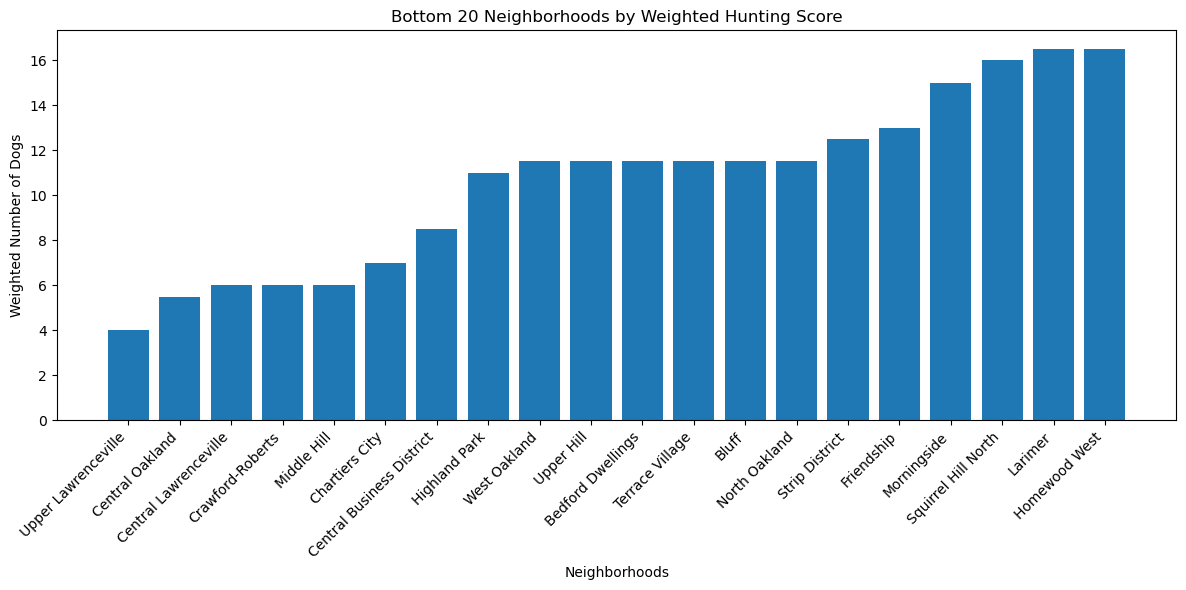

In [16]:
plot_bar(
    weighted_df.sort_values(by='WeightedScore', ascending=True),  # Sort ascending for lowest scores
    'Neighborhood',
    'WeightedScore',
    'Bottom 20 Neighborhoods by Weighted Hunting Score',
    top_n=20
)

Much better! Now we have a list of the twenty neighborhoods in the City of Pittsburgh with the least number of non hunting or tracking breed dogs, the best case scenario for a rat looking to avoid predators!

Looks like Upper Lawrenceville is the best neighborhood for a rat!!